In [237]:
!pip install numba

     |████████████████████████████████| 3.4MB 1.5MB/s eta 0:00:01
     |████████████████████████████████| 25.3MB 40.0MB/s eta 0:00:01


In [37]:
import torch
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

import os
import time

from utils import load_data

from math import log2
from numba import jit

from scipy.stats import entropy

from models import model_loader

In [2]:
import seaborn as sns
sns.set()
sns.set_palette("muted")

In [3]:
sparsity = np.concatenate((np.arange(0, 91, 10), np.arange(91, 100)))
uniform_dist = lambda n: np.array( [1/n for i in range(n)])

### MNIST - LeNet5

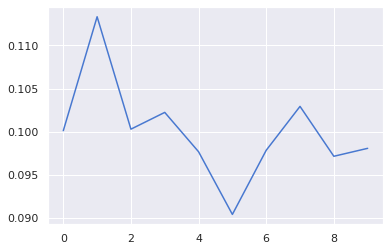

In [217]:
plt.plot(state['softmax_output'][0])

In [64]:
def get_sparsity(net):
    total_zeros = 0
    total_shapes = 0
    capacity = 0

    for name, module in net.named_modules():
        if isinstance(module, torch.nn.Linear):
            capacity += np.prod(module.weight.shape)
        if isinstance(module, torch.nn.Conv2d):
            zeros = module.weight[module.weight == 0]
            total_zeros += np.prod(zeros.shape)
            total_shapes += np.prod(module.weight.shape)
            capacity += (total_shapes - total_zeros)
    return total_zeros/total_shapes * 100, capacity

In [73]:
s = torch.load('runs/resnet18_10/sparsity%d/model_best.pth.tar'%sparsity)
state_dict = s['state_dict']
net = model_loader()
net.load_state_dict(state_dict)
spr, cap = get_sparsity(net)

In [72]:
cap

43592780

In [252]:
def cal_kl(state, uniform):
    
    total_kl = 0
    ran = state['softmax_output'].shape[0]
    for i in range(ran):
        total_kl += kl_divergence(state['softmax_output'][i], uniform)
        
    return total_kl / ran

In [29]:
idx = 15

entropy(np.sort(state['softmax_output'][idx])[-1], np.sort(state['softmax_output'][idx])[-2])

0.0

In [17]:
lenet_result = {
    'var': [],
    'mean': [],
    'sparsity': [],
    'loss': [],
    'f1': [],
    'auc': [],
    'acc': [],
    'kl': [],  # mean entropy between softmax distribution and uniform distribution
    'kl_var': [],
    'capacity': []
}

sparsity = np.concatenate((np.arange(0, 91, 10), np.arange(91, 100)))
uniform = uniform_dist(10)
uniform = np.tile(uniform, (60000,1))
for s in sparsity:
    state = load_data('./runs/l0LeNet_sparsecoding_result/sparsity%d/train.pkl' % s)
#     state = torch.load('./runs/l0LeNet_sparsecoding2/sparsity%d/checkpoint_train.pth.tar'%s)
    sd = torch.load('runs/resnet18_10/sparsity%d/model_best.pth.tar'%sparsity)
    state_dict = sd['state_dict']
    net = model_loader()
    net.load_state_dict(state_dict)
    spr, cap = get_sparsity(net)

    var_list = []
    mean_list = []
    loss_list = []
    f1_list = []
    auc_list = []
    for num in np.arange(0, 10):
        idxs = np.where(state['labels'] == num)[0]
        var, mean = state['softmax_output'][idxs].var(axis=0)[num], state['softmax_output'][idxs].mean(axis=0)[num]
        var_list.append(var)
        mean_list.append(mean)
    kl = entropy(state['softmax_output'], uniform, axis=1)
    print(kl.mean())
    lenet_result['kl'].append(kl.mean())
    lenet_result['kl_var'].append(kl.var())
    lenet_result['var'].append(var_list)
    lenet_result['mean'].append(mean_list)
    lenet_result['sparsity'].append(s)
    lenet_result['f1'].append(state['results']['f1'])
    lenet_result['auc'].append(state['results']['auc_score'])
    lenet_result['acc'].append(state['results']['accuracy'])
    lenet_result['loss'].append(state['loss'].tolist())
    lenet_result['capacity'].append(cap)

lenet_result['kl'] = np.array(lenet_result['kl'])
lenet_result['kl_var'] = np.array(lenet_result['kl_var'])
lenet_result['var'] = np.array(lenet_result['var'])
lenet_result['mean'] = np.array(lenet_result['mean'])
lenet_result['sparsity'] = np.array(lenet_result['sparsity'])
lenet_result['f1'] = np.array(lenet_result['f1'])
lenet_result['auc'] = np.array(lenet_result['auc'])
lenet_result['acc'] = np.array(lenet_result['acc'])
lenet_result['loss'] = np.array(lenet_result['loss'])

2.2998821530192606
2.300951128410395
2.3013546901501636
2.3019088668026506
2.3021995958404475
2.3006728853620992
2.3019329000058733
2.2985109843540354
2.288252454493839
2.2788230782653076
2.2824993468387604
2.2872310936420095
2.2825106147615775
2.2734747803039608
2.259458353442763
2.2367185200012814
2.223036544994791
2.095823524134898
0.0015058364302348941


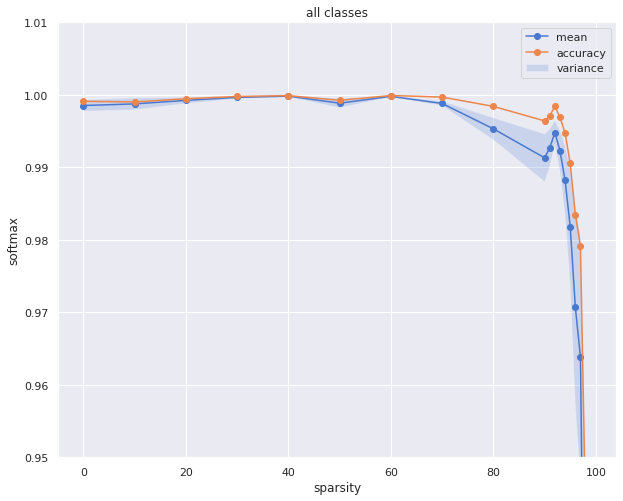

In [13]:
acc = lenet_result['acc']
var = lenet_result['var'].mean(axis=1)
mean = lenet_result['mean'].mean(axis=1)

plt.figure(figsize=(10,8))
plt.ylim((0.95, 1.01))
plt.plot(sparsity, mean, 'o-', label='mean')
plt.fill_between(sparsity, mean-var, mean+var, alpha=0.2, label='variance')
plt.plot(sparsity, lenet_result['acc'], 'o-', label='accuracy')
plt.xlabel('sparsity')
plt.ylabel('softmax')
plt.title('all classes')
plt.legend()
plt.show()

In [187]:
a = [(v-var[i-1])/var[i-1] * 100 for i, v in enumerate(var)]

In [179]:
a[0] = 0

a

[0,
 6.160115078091621,
 -47.97113239765167,
 -58.11105966567993,
 -49.829286336898804,
 614.1864776611328,
 -88.93707394599915,
 340.39173126220703,
 387.1721029281616,
 117.82599687576294,
 -20.379646122455597,
 -37.588831782341,
 71.39495015144348,
 68.88380646705627,
 69.58212852478027,
 69.09483671188354,
 23.684047162532806,
 144.8310136795044,
 -100.0]

Text(0, 0.5, 'accuracy')

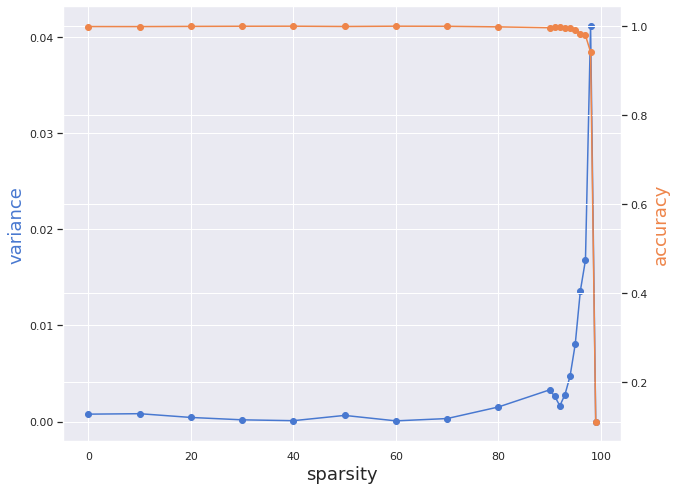

In [196]:
fig, ax1 = plt.subplots(figsize=(10,8))



ax2 = ax1.twinx()

ax1.plot(sparsity, var, '-o', c=sns.color_palette('muted')[0], label='variance')
ax2.plot(sparsity, acc, '-o', c=sns.color_palette('muted')[1], label='accuracy')

ax1.set_xlabel('sparsity', fontsize=18)
ax1.set_ylabel('variance', color=sns.color_palette('muted')[0], fontsize=18)
ax2.set_ylabel('accuracy', color=sns.color_palette('muted')[1], fontsize=18)

# ax1.legend()

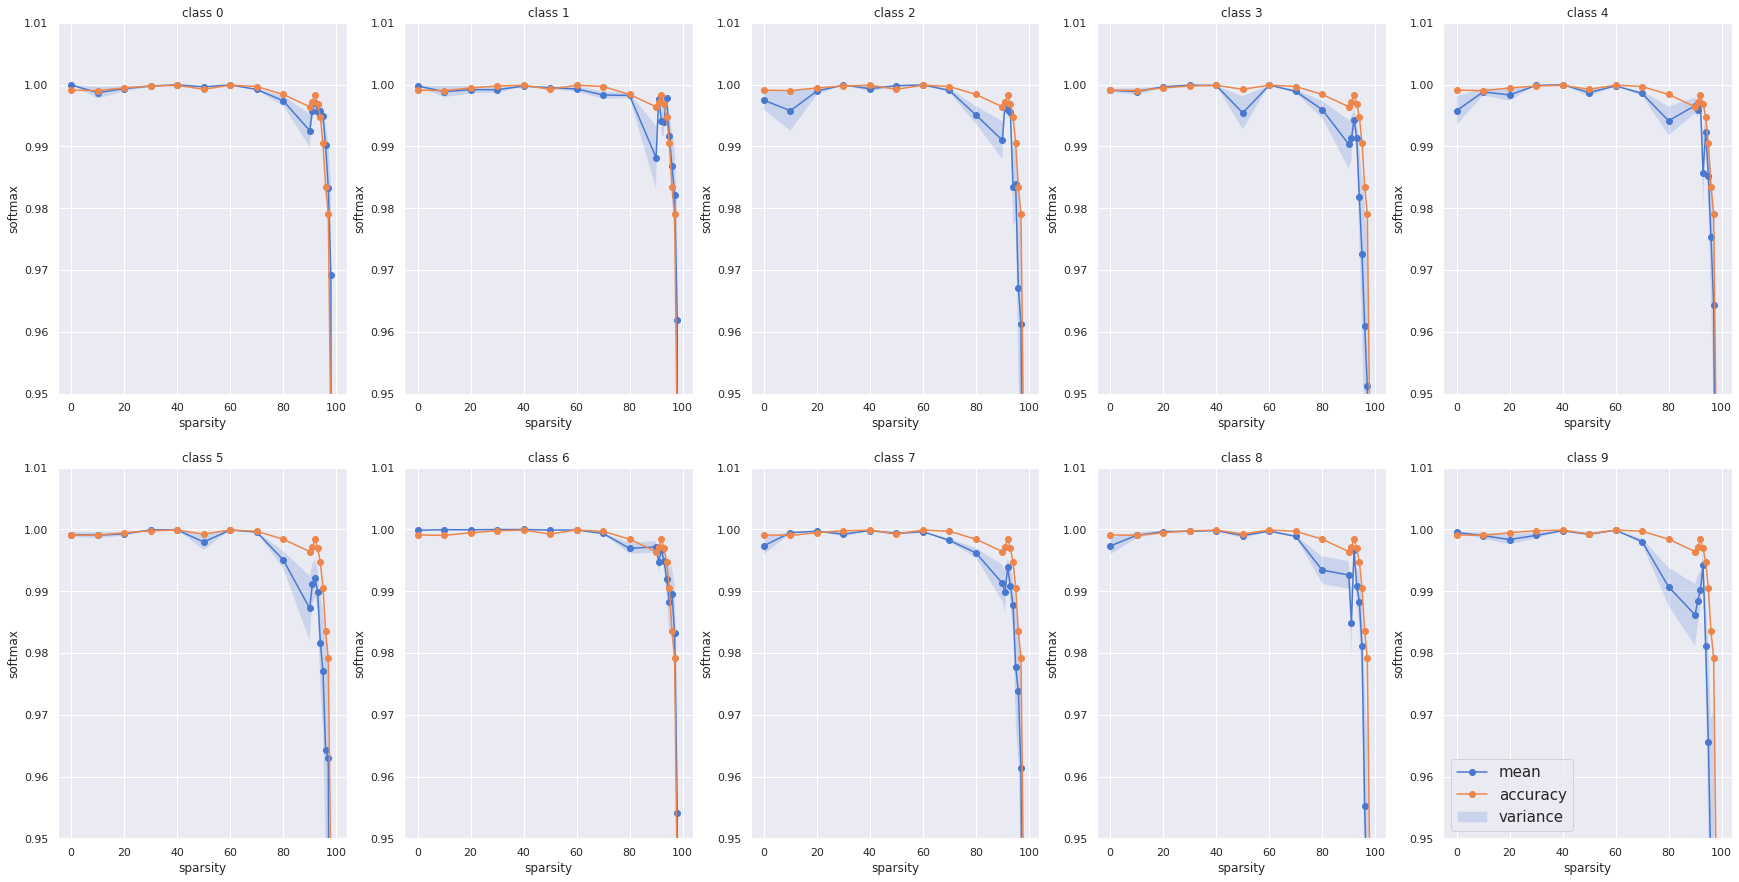

In [199]:
fig, axs = plt.subplots(2, 5, figsize=(30,15))

for num in np.arange(0, 10):
    
#     if num == 0:
#         ax = axs[0, 1]
#     else:
#         ax = axs[int((num-1)/3)+1, int((num-1)%3)] 
    
    ax = axs[int(num/5), int(num%5)]
    
    
    var = trainset_var_mean_per_sparsity['var'][:,num]
    mean = trainset_var_mean_per_sparsity['mean'][:,num]
    f1 = trainset_var_mean_per_sparsity['f1']
    acc = trainset_var_mean_per_sparsity['acc']
    
    ax.set_ylim((0.95, 1.01))

    ax.plot(sparsity, mean, 'o-', label='mean')
    ax.fill_between(sparsity, mean-var, mean+var, alpha=0.2, label='variance')
    ax.plot(sparsity, acc, 'o-', label='accuracy')
    
    ax.set(xlabel='sparsity', ylabel='softmax')
    ax.set_title('class %d' % num)
plt.legend(fontsize=15)


### ImageNet - 10class ResNet18

In [8]:
resnet_result = {
    'var': [],
    'mean': [],
    'sparsity': [],
    'loss': [],
    'f1': [],
    'auc': [],
    'acc': [],
    'val_acc': [],
    'kl': [],  # mean entropy between softmax distribution and uniform distribution
    'kl_var': []
}

sparsity = np.concatenate((np.arange(0, 91, 10), np.arange(91, 100)))
uniform = uniform_dist(10)
uniform = np.tile(uniform, (13000,1))

for s in sparsity:
    state = load_data('./runs/resnet18_10_sparsecoding_result/sparsity%d/train.pkl'%s)
    val_state = load_data('./runs/resnet18_10_sparsecoding_result/sparsity%d/valid.pkl'%s)
#     state = torch.load('./runs/l0LeNet_sparsecoding2/sparsity%d/checkpoint_train.pth.tar'%s)

    var_list = []
    mean_list = []
    loss_list = []
    f1_list = []
    auc_list = []
    for num in np.arange(0, 10):
        idxs = np.where(state['labels'] == num)[0]
        var, mean = state['softmax_output'][idxs].var(axis=0)[num], state['softmax_output'][idxs].mean(axis=0)[num]
        var_list.append(var)
        mean_list.append(mean)

    
    kl = entropy(state['softmax_output'], uniform, axis=1)
    print(kl.mean())
    resnet_result['kl'].append(kl.mean())
    resnet_result['kl_var'].append(kl.var())
    resnet_result['var'].append(var_list)
    resnet_result['mean'].append(mean_list)
    resnet_result['sparsity'].append(s)
    resnet_result['f1'].append(state['results']['f1'])
    resnet_result['auc'].append(state['results']['auc_score'])
    resnet_result['acc'].append(state['results']['accuracy'])
    resnet_result['val_acc'].append(val_state['results']['accuracy'])
    resnet_result['loss'].append(state['loss'].tolist())

resnet_result['kl'] = np.array(resnet_result['kl'])
resnet_result['kl_var'] = np.array(resnet_result['kl_var'])
resnet_result['var'] = np.array(resnet_result['var'])
resnet_result['mean'] = np.array(resnet_result['mean'])
resnet_result['sparsity'] = np.array(resnet_result['sparsity'])
resnet_result['f1'] = np.array(resnet_result['f1'])
resnet_result['auc'] = np.array(resnet_result['auc'])
resnet_result['acc'] = np.array(resnet_result['acc'])
resnet_result['val_acc'] = np.array(resnet_result['val_acc'])
resnet_result['loss'] = np.array(resnet_result['loss'])

1.6048473269044745
1.5938778004109297
1.6799745091520797
1.6291590384745052
1.589738768550006
1.6218084118670102
1.659273800745269
1.6531754263174163
1.610550399202624
1.6334934089811322
1.6610241740231935
1.6707811863925683
1.6628077678569428
1.5886946934334236
1.5877909827823913
1.5541334168656593
1.5872484562071885
1.5536602331193878
1.1220014861634324


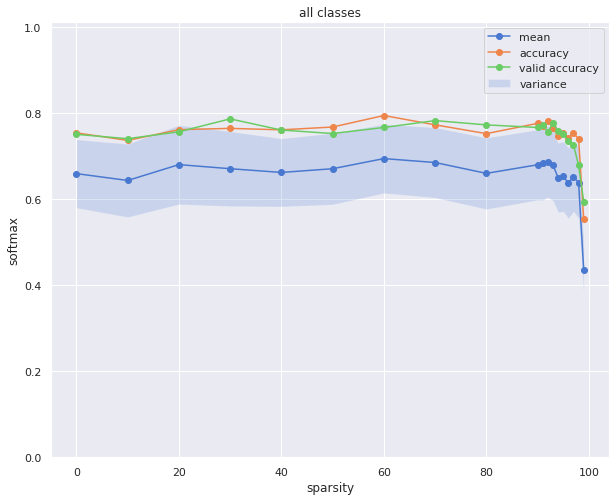

In [9]:
acc = resnet_result['acc']
valacc = resnet_result['val_acc']
var = resnet_result['var'].mean(axis=1)
mean = resnet_result['mean'].mean(axis=1)

plt.figure(figsize=(10,8))
plt.ylim((0., 1.01))
plt.plot(sparsity, mean, 'o-', label='mean')
plt.fill_between(sparsity, mean-var, mean+var, alpha=0.2, label='variance')
plt.plot(sparsity, resnet_result['acc'], 'o-', label='accuracy')
plt.plot(sparsity, resnet_result['val_acc'], 'o-', label='valid accuracy')
plt.xlabel('sparsity')
plt.ylabel('softmax')
plt.title('all classes')
plt.legend()
plt.show()

In [167]:
before = var[0]
for v, s in zip(var, sparsity):
    print(s, v, (v - before) / before * 100,'%')
    before = v

0 0.07954766 0.0 %
10 0.085149065 7.041572779417038 %
20 0.091986775 8.030282706022263 %
30 0.08691029 -5.518709495663643 %
40 0.07908909 -8.999166637659073 %
50 0.08300478 4.950986057519913 %
60 0.08006497 -3.541739284992218 %
70 0.08172705 2.0759178325533867 %
80 0.08305065 1.619541086256504 %
90 0.081862494 -1.4306437224149704 %
91 0.08554167 4.494339972734451 %
92 0.08304199 -2.9221834614872932 %
93 0.08305405 0.01452577271265909 %
94 0.08057681 -2.982688322663307 %
95 0.08148539 1.1275991797447205 %
96 0.08211489 0.77253058552742 %
97 0.08070904 -1.7120525240898132 %
98 0.08286445 2.670590952038765 %
99 0.060881753 -26.528501510620117 %


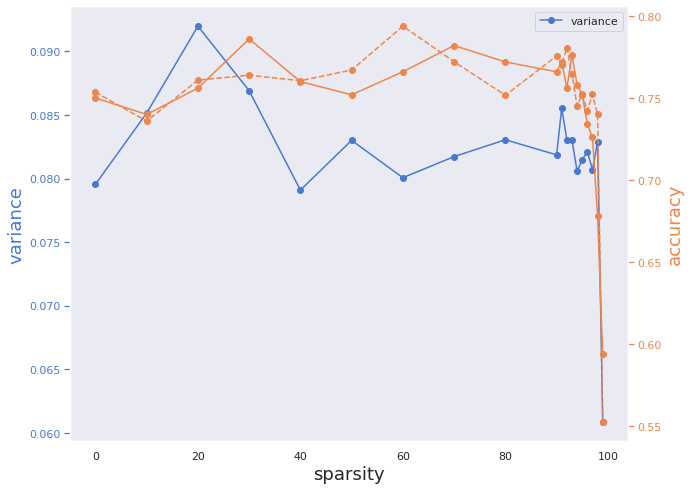

In [10]:
fig, ax1 = plt.subplots(figsize=(10,8))



ax2 = ax1.twinx()

ax1.plot(sparsity, var, '-o', c=sns.color_palette('muted')[0], label='variance')
ax2.plot(sparsity, acc, '--o', c=sns.color_palette('muted')[1], label='accuracy')
ax2.plot(sparsity, trainset_var_mean_per_sparsity['val_acc'], 'o-', c=sns.color_palette('muted')[1], label='valid accuracy')


ax1.grid(False)
ax1.set_xlabel('sparsity', fontsize=18)
ax1.set_ylabel('variance', c=sns.color_palette('muted')[0], fontsize=18)
ax1.tick_params(axis='y', colors=sns.color_palette('muted')[0])
ax2.set_ylabel('accuracy', c=sns.color_palette('muted')[1], fontsize=18)
ax2.tick_params(axis='y', colors=sns.color_palette('muted')[1])
ax2.grid(False)
ax1.legend()

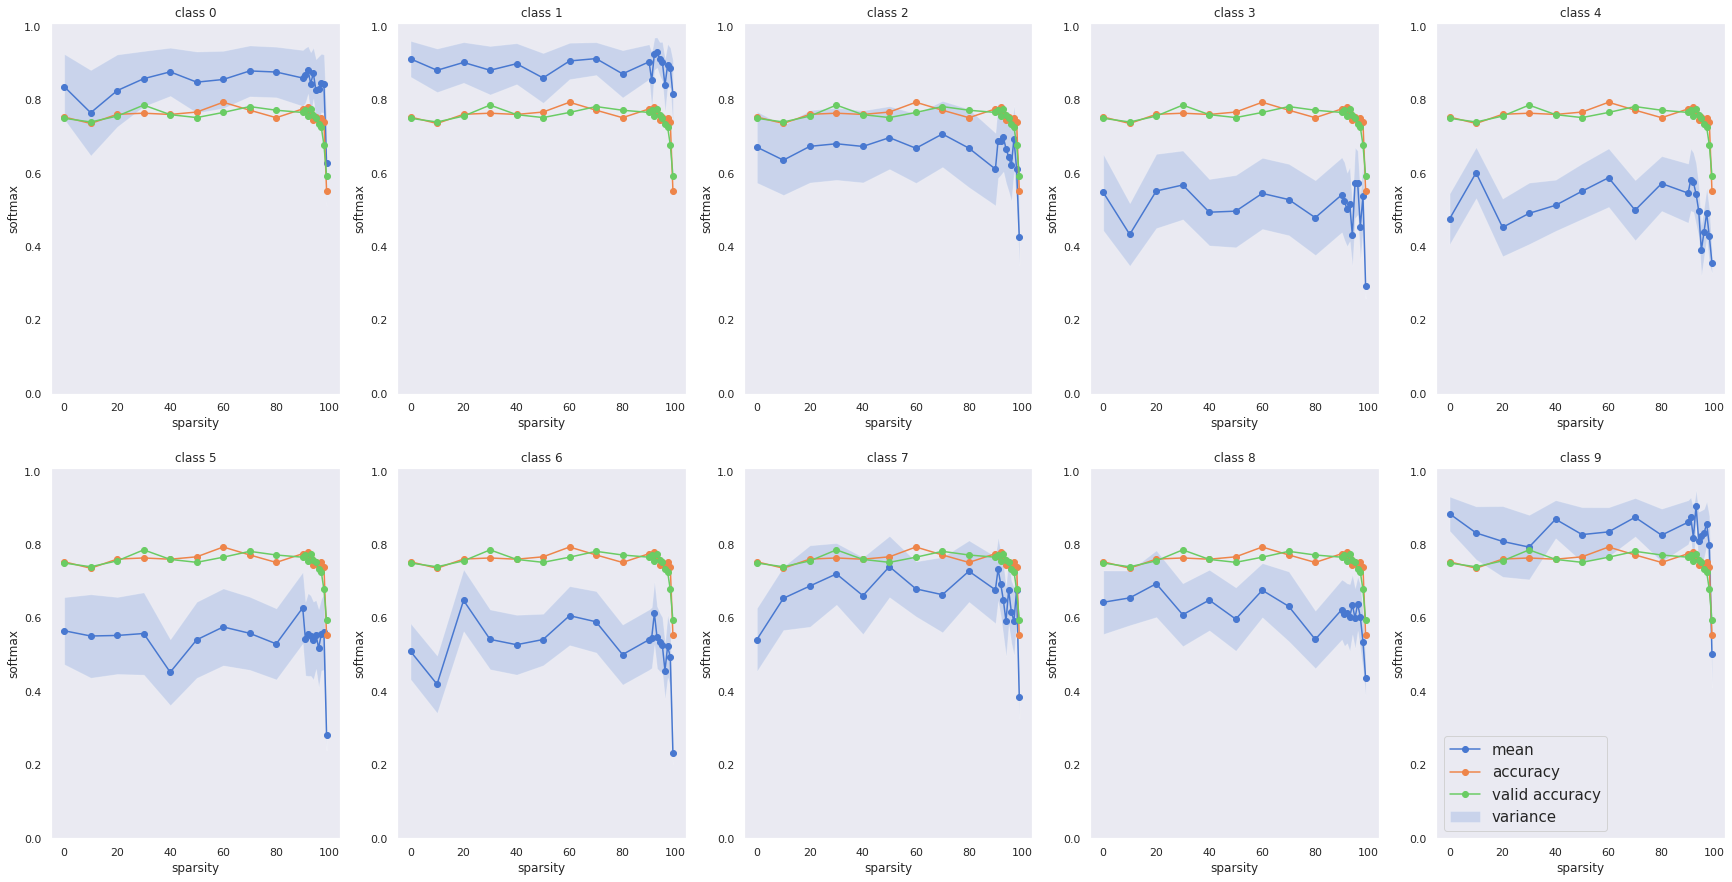

In [11]:
fig, axs = plt.subplots(2, 5, figsize=(30,15))

for num in np.arange(0, 10):
    
#     if num == 0:
#         ax = axs[0, 1]
#     else:
#         ax = axs[int((num-1)/3)+1, int((num-1)%3)] 
    
    ax = axs[int(num/5), int(num%5)]
    ax.grid(False)
    
    
    var = resnet_result['var'][:,num]
    mean = resnet_result['mean'][:,num]
    f1 = resnet_result['f1']
    acc = resnet_result['acc']
    
    ax.set_ylim((0., 1.01))

    ax.plot(sparsity, mean, 'o-', label='mean')
    ax.fill_between(sparsity, mean-var, mean+var, alpha=0.2, label='variance')
    ax.plot(sparsity, acc, 'o-', label='accuracy')
    ax.plot(sparsity, trainset_var_mean_per_sparsity['val_acc'], 'o-', label='valid accuracy')
    ax.set(xlabel='sparsity', ylabel='softmax')
    ax.set_title('class %d' % num)
plt.legend(fontsize=15)


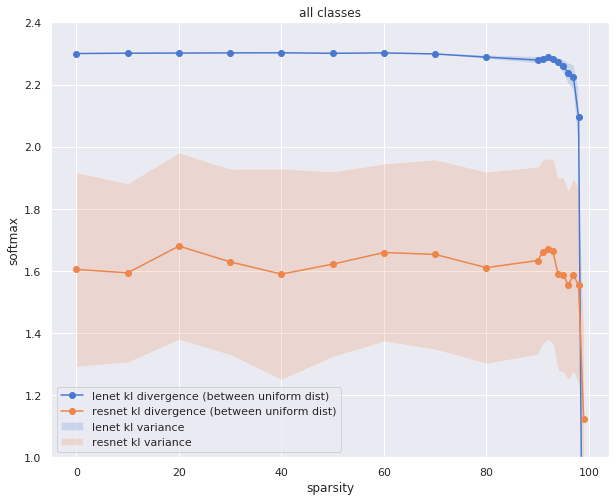

In [16]:
# acc = trainset_var_mean_per_sparsity['acc']
# var = trainset_var_mean_per_sparsity['var'].mean(axis=1)
# mean = trainset_var_mean_per_sparsity['mean'].mean(axis=1)

plt.figure(figsize=(10,8))
plt.ylim((1, 2.4))
plt.plot(sparsity, lenet_result['kl'], 'o-', label='lenet kl divergence (between uniform dist)')
plt.fill_between(sparsity, lenet_result['kl']-lenet_result['kl_var'], lenet_result['kl']+lenet_result['kl_var'], alpha=0.2, label='lenet kl variance')
plt.plot(sparsity, resnet_result['kl'], 'o-', label='resnet kl divergence (between uniform dist)')
plt.fill_between(sparsity, resnet_result['kl']-resnet_result['kl_var'], resnet_result['kl']+resnet_result['kl_var'], alpha=0.2, label='resnet kl variance')
# plt.plot(sparsity, trainset_var_mean_per_sparsity['acc'], 'o-', label='accuracy')
plt.xlabel('sparsity')
plt.ylabel('softmax')
plt.title('all classes')
plt.legend()
plt.show()

In [ ]:
# kl divergence (softmax distribution의 uniform distribution에 대한 kl divergence) 의 경우 모델 capacity가 커질 수록 kl divergence의 variance가 큰 것을 확인
# 